# Analyze of performance / time LLM

In [4]:
from pandas import read_csv
import matplotlib.pyplot as plt
import json

In [26]:
df_log

,id,input,output,time,success
0,27855,n_input=1996,n_output=2562,14.693747,False
1,53341,n_input=660,n_output=729,2.118952,True
2,46705,n_input=687,n_output=759,2.148801,True
3,14760,n_input=704,n_output=786,2.555505,True
4,48185,n_input=991,n_output=1153,4.321486,True
...,...,...,...,...,...
448,5000,n_input=701,n_output=795,2.788702,True
449,32747,n_input=845,n_output=940,3.147001,True
450,41138,n_input=788,n_output=850,2.365376,True
451,44711,n_input=712,n_output=785,2.511768,True


In [36]:
df_log = read_csv(
    "./log/llm_0.log",
    sep=";",
    skiprows=5,
    header=None,
    names=["id", "input", "output", "time", "success"],
)


In [37]:
df_log.loc[:, "id"] = df_log["id"].map(lambda x: x.split(":")[-1])
df_log.loc[:, "input"] = df_log["input"].map(lambda x: x.split("=")[-1]).astype(float)
df_log.loc[:, "output"] = df_log["output"].map(lambda x: x.split("=")[-1]).astype(float)

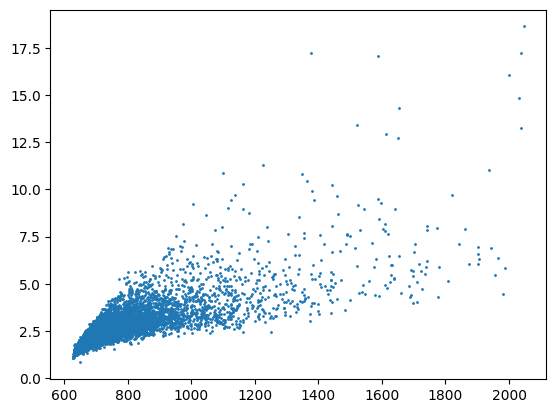

In [38]:
from matplotlib import ticker

df_scatter = df_log[df_log.success == True]
plt.scatter(
    x=df_scatter.input.values,
    y=df_scatter.time.values,
    s=1)
plt.show()

In [2]:
question = (
    """Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?"""
)
treatment = """- create a dict / json documet with the following keys: relevant, main_content, keyword
- reply "true" or "false" if the text answers the question. key:"relevant"
- extracts the main ideas and propositions from the text into a list.
- reformulates these main ideas and propositions with an infinitive verb and an action. key:"main_content"
- determines the word, feeling, emotion or quality that summarize the content with 0 to 5 keywords. key:"keyword".
"""
system_prompt = f"""
- Treat the text as a french analyst who works in economical, tax, financial and public policy.
- Applies the following analysis treatment and return the responses in JSON format.
- respect the JSON format at all cost.
- answers with less than 3000-tokens-words.

question : ```{question}```
treatment : ```{treatment}```
"""

example_user_1 = f"""text : ```--- 1) Réforme de l'impôt sur le revenu : il faut un paiement de l'impôt par tous dés le 1er euro perçu en prenant en compte tous les revenus.
2) Remise à plat de toutes les niches fiscales et suppression de celles inefficaces et inutiles.
2) Suppression de la taxe d'habitation pour 100% des français et non pas 80% car si cet impôt est bête et injuste , il l'est pour l'ensemble des français.
3) Taxation des entreprises à un taux réel avec là aussi une revue des niches, crédits d'impôts et autres réductions qui permettent à bcp d'entreprises de se soustraire à l'impôt.
```"""
example_assistant_1 = """{"relevant":true,
"main_content": ["payer l'impôt sur le revenu dés le 1er euro perçu", "supprimer les niches fiscales", "supprimer la taxe d'habitation", "Taxer les entreprises à un taux réel"],
"keyword":["justice", "réforme", "égalité"]}"""

example_user_2 = (
    """Que tous les français devraient travailler, ça nous coûterait moins cher."""
)
example_assistant_2 = """{"relevant":false,
"main_content": ["avoir tous les français au travail"],
"keyword":["travail"]}"""

In [5]:
msg = [
    {"role":"system", "content":system_prompt},
    {"role": "user", "content": example_user_1},
    {"role": "assistant", "content": example_assistant_1},
    {"role": "user", "content": example_user_2},
    {"role": "assistant", "content": example_assistant_2}
]

In [7]:
json.dumps(msg, "../data/prompt/2048_extract_export.json")

AttributeError: 'str' object has no attribute 'write'

In [8]:
import json

with open("../data/prompt/2048_extract_export.json", 'w') as f:
    json.dump(msg, f)

In [14]:
import panel as pn
import altair as alt
from vega_datasets import data
import pandas as pd

penguins_url = (
    "https://raw.githubusercontent.com/vega/vega/master/docs/data/penguins.json"
)

pn.extension("vega")
df = pd.read_json(penguins_url)

brush = alt.selection_interval(name="brush")  # selection of type "interval"

chart = (
    alt.Chart(penguins_url)
    .mark_point()
    .encode(
        x=alt.X("Beak Length (mm):Q", scale=alt.Scale(zero=False)),
        y=alt.Y("Beak Depth (mm):Q", scale=alt.Scale(zero=False)),
        color=alt.condition(brush, "Species:N", alt.value("lightgray")),
    )
    .properties(width=250, height=250)
    .add_params(brush)
)


def selected_row(selection):
    try:
        text_area.value = selection.value
    except:
        pass


def filtered_table(selection):
    if not selection:
        return "## No selection"
    query = " & ".join(
        f"{crange[0]:.3f} <= `{col}` <= {crange[1]:.3f}"
        for col, crange in selection.items()
    )
    global df_pane
    df_pane = pn.widgets.Tabulator(df.query(query), width=600, height=300)
    df_pane.on_click(selected_row)
    return pn.Column(df_pane)


text_area = pn.widgets.StaticText(
    name="",
)
vega_pane = pn.pane.Vega(chart, debounce=10)
app = pn.Column(
    pn.Row(vega_pane, pn.bind(filtered_table, vega_pane.selection.param.brush)),
    text_area,
)
app.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'d0eadc34-ac0d-406c-af3f-6810ae17ad10': {'version…